## MRI Brain Tumour Segmentation using U-Net Deep Learning Model

References:
- https://arxiv.org/pdf/1505.04597
- https://github.com/adityajn105/brain-tumor-segmentation-unet/blob/master/brain_tumor_segmentation.ipynb

### Import necessary libraries

In [10]:
import json
import matplotlib.pyplot as plt
import keras_tuner as kt

from utils import *
from keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, Dropout, Input, BatchNormalization, Flatten, Dense
from keras.models import Model, load_model
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import StratifiedKFold, KFold
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

### Data Preperation

In [11]:
# Parameters
IMG_HEIGHT, IMG_WIDTH = 224, 224
BATCH_SIZE = 32
NUM_CLASSES = 4 

# Create ImageDataGenerator for training data
train_datagen = ImageDataGenerator(
    rescale=1./255,         # Rescale the image to 0-1
    validation_split=0.2    # Split data into training and validation
    # rotation_range=10,      # Random rotation up to 10 degrees
    # width_shift_range=0.1,  # Random horizontal shift by up to 10% of image width
    # height_shift_range=0.1, # Random vertical shift by up to 10% of image height
    # zoom_range=0.1,         # Random zooming by up to 10%
    # zoom_range=[.9,1.1],    # Random zooming by up to 10% or down to 10%
    # horizontal_flip=True,   # Random horizontal flipping
    # fill_mode='nearest',    # Fill mode for pixels outside the input boundaries
)

# Create ImageDataGenerator for validation data
valid_datagen = ImageDataGenerator(
    rescale=1./255,         # Rescale the image to 0-1
    validation_split=0.2    # Split data into training and validation
)

# Create training generator
train_generator = train_datagen.flow_from_directory(
    DATASET_FOLDER,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=19032024
)

# Create validation generator
validation_generator = valid_datagen.flow_from_directory(
    DATASET_FOLDER,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=True,
    seed=19032024
)

# Check the shape of your training data
for images, labels in train_generator:
    print("Shape of images batch:", images.shape)
    print("Shape of labels batch:", labels.shape)
    break

Found 380 images belonging to 4 classes.
Found 95 images belonging to 4 classes.
Shape of images batch: (32, 224, 224, 3)
Shape of labels batch: (32, 4)


In [12]:
# Get class names
class_names = list(train_generator.class_indices.keys())
print("Training classes:", class_names)
class_names = list(validation_generator.class_indices.keys())
print("Validation classes:", class_names)

Training classes: ['glioma', 'meningioma', 'notumor', 'pituitary']
Validation classes: ['glioma', 'meningioma', 'notumor', 'pituitary']


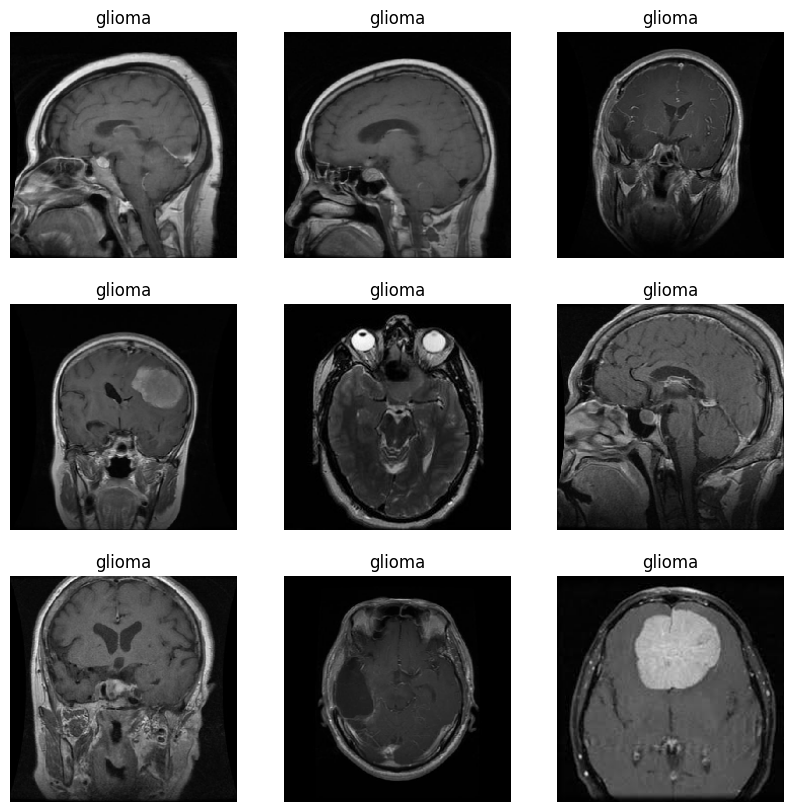

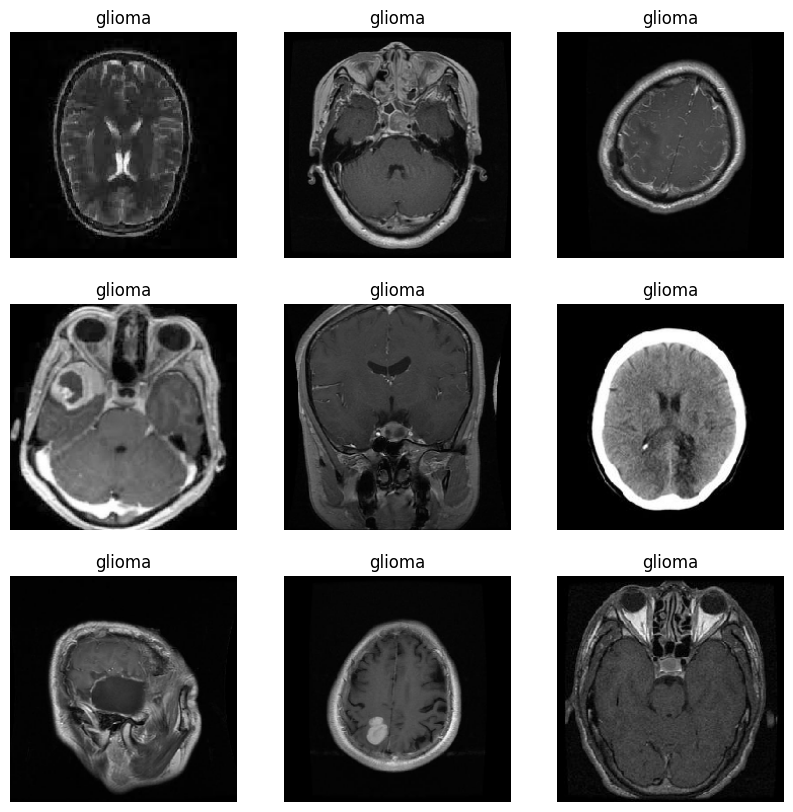

In [13]:
# Preview training dataset
sample_data_train = train_generator.__getitem__(1)[0]
sample_label_train = train_generator.__getitem__(1)[1]

plt.figure(figsize=(10, 10))

for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(sample_data_train[i])
    plt.title(class_names[np.argmax(sample_label_train[i].argmax())])
    plt.axis("off")

# Preview validation dataset
sample_data_validation = validation_generator.__getitem__(1)[0]
sample_label_validation = validation_generator.__getitem__(1)[1]

plt.figure(figsize=(10, 10))

for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(sample_data_validation[i])
    plt.title(class_names[np.argmax(sample_label_validation[i].argmax())])
    plt.axis("off")

### Model Creation

In [14]:
IMG_DIM = (IMG_HEIGHT, IMG_WIDTH, 3)

def conv2d_block(input_tensor, n_filters, kernel_size=(3,3), name="contraction"):
    "Add 2 conv layers"
    x = Conv2D(filters=n_filters, kernel_size=kernel_size, kernel_initializer='he_normal', 
               padding='same', activation="relu", name=name+'_1')(input_tensor)
    x = Conv2D(filters=n_filters, kernel_size=kernel_size, kernel_initializer='he_normal', 
               padding='same', activation="relu", name=name+'_2')(x)
    return x

def build_model(hp):
    inp = Input(shape=IMG_DIM)

    # Encoder
    d1 = conv2d_block(inp, hp.Int('filters_1', 32, 128, step=32), name="contraction_1")
    p1 = MaxPooling2D(pool_size=(2,2), strides=(2,2))(d1)
    p1 = BatchNormalization(momentum=0.8)(p1)
    p1 = Dropout(hp.Float('dropout_1', 0.1, 0.5, step=0.1))(p1)

    d2 = conv2d_block(p1, hp.Int('filters_2', 64, 256, step=64), name="contraction_2")
    p2 = MaxPooling2D(pool_size=(2,2), strides=(2,2))(d2)
    p2 = BatchNormalization(momentum=0.8)(p2)
    p2 = Dropout(hp.Float('dropout_2', 0.1, 0.5, step=0.1))(p2)

    d3 = conv2d_block(p2, hp.Int('filters_3', 128, 512, step=128), name="contraction_3")
    p3 = MaxPooling2D(pool_size=(2,2), strides=(2,2))(d3)
    p3 = BatchNormalization(momentum=0.8)(p3)
    p3 = Dropout(hp.Float('dropout_3', 0.1, 0.5, step=0.1))(p3)

    d4 = conv2d_block(p3, hp.Int('filters_4', 256, 512, step=256), name="contraction_4")
    p4 = MaxPooling2D(pool_size=(2,2), strides=(2,2))(d4)
    p4 = BatchNormalization(momentum=0.8)(p4)
    p4 = Dropout(hp.Float('dropout_4', 0.1, 0.5, step=0.1))(p4)

    d5 = conv2d_block(p4, hp.Int('filters_5', 256, 512, step=256), name="contraction_5")

    # Decoder
    u1 = Conv2DTranspose(hp.Int('filters_5', 256, 512, step=256), (3, 3), strides=(2, 2), padding='same')(d5)
    u1 = concatenate([u1, d4])
    u1 = Dropout(hp.Float('dropout_5', 0.1, 0.5, step=0.1))(u1)
    c1 = conv2d_block(u1, hp.Int('filters_4', 256, 512, step=256), name="expansion_1")

    u2 = Conv2DTranspose(hp.Int('filters_4', 256, 512, step=256), (3, 3), strides=(2, 2), padding='same')(c1)
    u2 = concatenate([u2, d3])
    u2 = Dropout(hp.Float('dropout_4', 0.1, 0.5, step=0.1))(u2)
    c2 = conv2d_block(u2, hp.Int('filters_3', 128, 512, step=128), name="expansion_2")

    u3 = Conv2DTranspose(hp.Int('filters_3', 128, 512, step=128), (3, 3), strides=(2, 2), padding='same')(c2)
    u3 = concatenate([u3, d2])
    u3 = Dropout(hp.Float('dropout_3', 0.1, 0.5, step=0.1))(u3)
    c3 = conv2d_block(u3, hp.Int('filters_2', 64, 256, step=64), name="expansion_3")

    u4 = Conv2DTranspose(hp.Int('filters_2', 64, 256, step=64), (3, 3), strides=(2, 2), padding='same')(c3)
    u4 = concatenate([u4, d1])
    u4 = Dropout(hp.Float('dropout_2', 0.1, 0.5, step=0.1))(u4)
    c4 = conv2d_block(u4, hp.Int('filters_1', 32, 128, step=32), name="expansion_4")

    # Final classification layer
    flattened = Flatten()(c4)
    out = Dense(NUM_CLASSES, activation='softmax', name="output")(flattened)

    unet = Model(inp, out)

    unet.compile(optimizer=Adam(hp.Float('learning_rate', 1e-4, 1e-2, sampling='LOG')), 
                 loss='categorical_crossentropy', 
                 metrics=['accuracy'])

    return unet

# Test if the model builds successfully
build_model(kt.HyperParameters())

<Functional name=functional_3, built=True>

### Fine Tuning

In [15]:
# Tuning settings
tuner = kt.Hyperband(build_model,
                     objective='val_accuracy',
                     max_epochs=25,
                     directory="hyperparameter-search",
                     project_name="brain-tumor-classification",
)

In [16]:
# Perform search
tuner.search(train_generator, epochs=25, validation_data=validation_generator)

Trial 27 Complete [01h 51m 52s]
val_accuracy: 0.2526315748691559

Best val_accuracy So Far: 0.7473683953285217
Total elapsed time: 20h 37m 30s

Search: Running Trial #28

Value             |Best Value So Far |Hyperparameter
96                |128               |filters_1
0.5               |0.5               |dropout_1
128               |128               |filters_2
0.4               |0.1               |dropout_2
256               |128               |filters_3
0.3               |0.5               |dropout_3
256               |512               |filters_4
0.5               |0.5               |dropout_4
512               |512               |filters_5
0.3               |0.4               |dropout_5
0.007559          |0.00082231        |learning_rate
25                |25                |tuner/epochs
0                 |9                 |tuner/initial_epoch
0                 |2                 |tuner/bracket
0                 |2                 |tuner/round

Epoch 1/25
12/12 ━━━━━━━━━━━━━━━

KeyboardInterrupt: 

In [17]:
# Retrieve the best hyperparameters found
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Print the best hyperparameters
print("Best Hyperparameters:")
print(f"filters_1: {best_hps.get('filters_1')}")
print(f"dropout_1: {best_hps.get('dropout_1')}")
print(f"filters_2: {best_hps.get('filters_2')}")
print(f"dropout_2: {best_hps.get('dropout_2')}")
print(f"filters_3: {best_hps.get('filters_3')}")
print(f"dropout_3: {best_hps.get('dropout_3')}")
print(f"filters_4: {best_hps.get('filters_4')}")
print(f"dropout_4: {best_hps.get('dropout_4')}")
print(f"filters_5: {best_hps.get('filters_5')}")
print(f"dropout_5: {best_hps.get('dropout_5')}")
print(f"learning_rate: {best_hps.get('learning_rate')}")

Best Hyperparameters:
filters_1: 128
dropout_1: 0.5
filters_2: 128
dropout_2: 0.1
filters_3: 128
dropout_3: 0.5
filters_4: 512
dropout_4: 0.5
filters_5: 512
dropout_5: 0.4
learning_rate: 0.000822314112616515


### Model Training

In [18]:
# Create callbacks
model_checkpoint = ModelCheckpoint('./models/unet_best_checkpoint.keras', 
                                   save_best_only=True,
                                   monitor='val_accuracy',
                                   mode='max',
                                   verbose=1
                                   )
# reduceLR = ReduceLROnPlateau(patience=4, verbose=2, monitor='val_loss',min_lr=1e-4, mode='min')
# early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode='min')

# Define callback list
callback_list = [model_checkpoint]

model = tuner.hypermodel.build(best_hps)

In [19]:
# Train the model
hist = model.fit(train_generator, epochs=50, validation_data=validation_generator, verbose=1, callbacks=callback_list)

# Export latest model
model.save(MODEL_FILE)

Epoch 1/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 36s/step - accuracy: 0.3101 - loss: 425.9236 
Epoch 1: val_accuracy improved from -inf to 0.48421, saving model to ./models/unet_best_checkpoint.keras
12/12 ━━━━━━━━━━━━━━━━━━━━ 530s 38s/step - accuracy: 0.3154 - loss: 409.4164 - val_accuracy: 0.4842 - val_loss: 1.3266
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 27s/step - accuracy: 0.4476 - loss: 1.3085 
Epoch 2: val_accuracy did not improve from 0.48421
12/12 ━━━━━━━━━━━━━━━━━━━━ 348s 29s/step - accuracy: 0.4512 - loss: 1.3063 - val_accuracy: 0.4737 - val_loss: 1.2529
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 27s/step - accuracy: 0.6090 - loss: 1.0346 
Epoch 3: val_accuracy improved from 0.48421 to 0.52632, saving model to ./models/unet_best_checkpoint.keras
12/12 ━━━━━━━━━━━━━━━━━━━━ 352s 30s/step - accuracy: 0.6106 - loss: 1.0293 - val_accuracy: 0.5263 - val_loss: 1.1357
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 27s/step - accuracy: 0.7140 - loss: 0.7706 
Epoch 4: val_accuracy improved from 0.526

### Model Evaluation

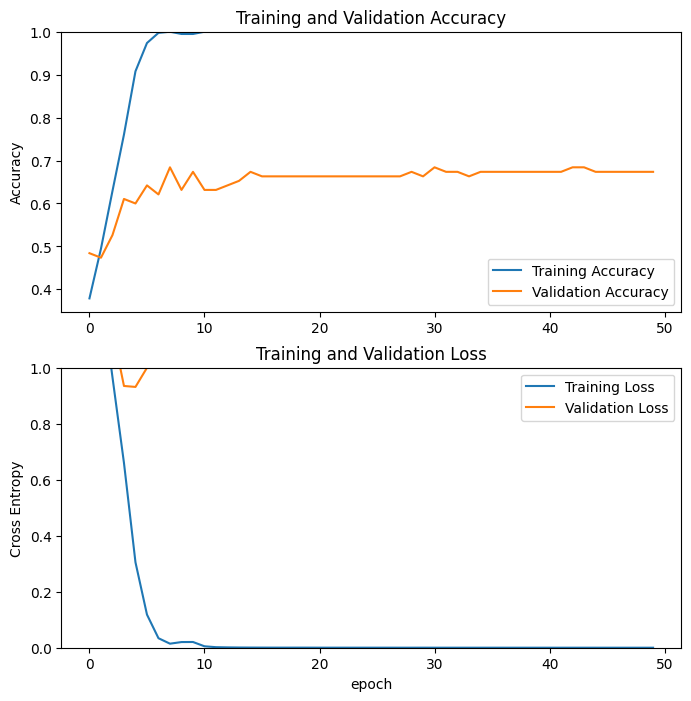

3/3 ━━━━━━━━━━━━━━━━━━━━ 25s 8s/step - accuracy: 0.6572 - loss: 1.5528
Test Accuracy : 0.6736842393875122
Test Loss : 1.5665690898895264
3/3 ━━━━━━━━━━━━━━━━━━━━ 25s 8s/step - accuracy: 0.6728 - loss: 1.6621
Validation Accuracy: 0.67


In [20]:
# View training metrics across epochs
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

loss = hist.history['loss']
val_loss = hist.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()), 1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0, 1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Test metrics
loss, accuracy = model.evaluate(validation_generator)
print('Test Accuracy :', accuracy)
print('Test Loss :', loss)

# Evaluate the model
loss, accuracy = model.evaluate(validation_generator)
print(f'Validation Accuracy: {accuracy:.2f}')


In [13]:
# Load the best model
model = keras.models.load_model('./models/unet_best_checkpoint.keras')

# Load the last model
# model = keras.models.load_model('./models/unet_model.keras')

In [26]:
# # Load images and labels
# images, labels, class_names = load_data(DATASET_FOLDER)

# # Train-Test split
# x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, stratify=labels, random_state=1234)

# def preprocess(image, label):
#     image = tf.image.resize(image, (IMG_HEIGHT, IMG_WIDTH))
#     image = tf.cast(image, tf.float32) / 255.0 
#     return image, label

# # Create TensorFlow datasets
# train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).map(preprocess).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
# val_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).map(preprocess).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

# Get training and validation datasets
train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
  DATASET_FOLDER,
  validation_split=0.2,
  subset="both",
  shuffle=True,
  seed=RANDOM_STATE,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=BATCH_SIZE)

# Get class names
class_names = train_ds.class_names
# class_names = val_ds.class_names

# Enable buffered prefetching to overlap data preprocessing and model execution during training, to speed up access to dataset
train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

Found 475 files belonging to 4 classes.
Using 380 files for training.
Using 95 files for validation.


In [27]:
print("Training Metrics")
get_model_metrics(train_ds, model)

print("\nValidation Metrics")
get_model_metrics(val_ds, model)

Training Metrics


2024-06-20 00:23:27.739082: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Accuracy: 0.7263157894736842
Precision: 0.8074491008317055
Recall: 0.7304545341307634
F1 Score: 0.6941235268129092
Matthews Correlation Coefficient (MCC): 0.6690385998363535
Cohen's Kappa: 0.6360421424887645
Hamming Loss: 0.2736842105263158

Confusion Matrix:
 [[22 31 44  0]
 [ 0 87  6  0]
 [ 0  4 90  0]
 [ 1  5 13 77]]

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.23      0.37        97
           1       0.69      0.94      0.79        93
           2       0.59      0.96      0.73        94
           3       1.00      0.80      0.89        96

    accuracy                           0.73       380
   macro avg       0.81      0.73      0.69       380
weighted avg       0.81      0.73      0.69       380




Validation Metrics
Accuracy: 0.7263157894736842
Precision: 0.803009828009828
Recall: 0.7233293075684379
F1 Score: 0.6835881132756133
Matthews Correlation Coefficient (MCC): 0.6628535984402999
Cohen's Kappa: 0.633422

2024-06-20 00:23:53.078720: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


### K-Fold Cross-Validation

In [29]:
# Load dataset without validation split
dataset = tf.keras.utils.image_dataset_from_directory(
    DATASET_FOLDER,
    shuffle=True,
    seed=RANDOM_STATE,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE
)

# Convert dataset to numpy arrays for k-fold splitting
images = []
labels = []
for image, label in dataset:
    images.append(image.numpy())
    labels.append(label.numpy())
images = np.concatenate(images)
labels = np.concatenate(labels)

labels = tf.keras.utils.to_categorical(labels, num_classes=NUM_CLASSES)

# K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# Initialise lists to store results
list_kf_results = []
list_skf_results = []

print("K-Fold Cross-Validation")
fold_no = 0
for train_index, val_index in kf.split(images):
    # Split data
    train_images, val_images = images[train_index], images[val_index]
    train_labels, val_labels = labels[train_index], labels[val_index]
    
    # Create TensorFlow datasets
    train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
    val_ds = tf.data.Dataset.from_tensor_slices((val_images, val_labels))

    # Prefetch datasets
    train_ds = train_ds.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
    val_ds = val_ds.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

    model = tuner.hypermodel.build(best_hps)

    # Train the model
    history = model.fit(train_ds, validation_data=val_ds, epochs=10, batch_size=32, verbose=0)
    
    # Evaluate the model
    train_loss, train_accuracy = model.evaluate(train_ds, verbose=0)
    val_loss, val_accuracy = model.evaluate(val_ds, verbose=0)
    
    # Save results
    list_kf_results.append({"train_loss": train_loss, "train_accuracy": train_accuracy, "val_loss": val_loss, "val_accuracy": val_accuracy, "history": history})
    
    print("Fold Index", fold_no)
    print("~Training Dataset~\nAccuracy: {}, Loss: {}".format(train_accuracy, train_loss))
    print("~Validation Dataset~\nAccuracy: {}, Loss: {}".format(val_accuracy, val_loss), end="\n\n")
    
    # Increment fold number
    fold_no += 1
    
print("\nStratified K-Fold Cross-Validation")
fold_no = 0
for train_index, val_index in skf.split(images, labels):
    # Split data
    train_images, val_images = images[train_index], images[val_index]
    train_labels, val_labels = labels[train_index], labels[val_index]
    
    # Create TensorFlow datasets
    train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
    val_ds = tf.data.Dataset.from_tensor_slices((val_images, val_labels))

    # Prefetch datasets
    train_ds = train_ds.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
    val_ds = val_ds.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

    model = tuner.hypermodel.build(best_hps)

    # Train the model
    history = model.fit(train_ds, validation_data=val_ds, epochs=10, batch_size=32, verbose=0)
    
    # Evaluate the model
    train_loss, train_accuracy = model.evaluate(train_ds, verbose=0)
    val_loss, val_accuracy = model.evaluate(val_ds, verbose=0)
    
    # Save results
    list_skf_results.append({"train_loss": train_loss, "train_accuracy": train_accuracy, "val_loss": val_loss, "val_accuracy": val_accuracy, "history": history})
    
    print("Fold Index", fold_no)
    print("~Training Dataset~\nAccuracy: {}, Loss: {}".format(train_accuracy, train_loss))
    print("~Validation Dataset~\nAccuracy: {}, Loss: {}".format(val_accuracy, val_loss), end="\n\n")
    
    # Increment fold number
    fold_no += 1

Found 475 files belonging to 4 classes.
K-Fold Cross-Validation


2024-06-20 00:25:12.150168: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


KeyboardInterrupt: 

In [ ]:
# Calculate statistics
def calculate_statistics(data):
    return {
        'max': np.max(data),
        'min': np.min(data),
        'median': np.median(data),
        'mean': np.mean(data)
    }

print("K-Fold Cross-Validation Results")
# Extract values
train_accuracies = [result['train_accuracy'] for result in list_kf_results]
train_losses = [result['train_loss'] for result in list_kf_results]
val_accuracies = [result['val_accuracy'] for result in list_kf_results]
val_losses = [result['val_loss'] for result in list_kf_results]

# Print results
print(json.dumps({
    'Training Accuracy': calculate_statistics(train_accuracies),
    'Training Loss': calculate_statistics(train_losses),
    'Validation Accuracy': calculate_statistics(val_accuracies),
    'Validation Loss': calculate_statistics(val_losses)
}, indent=4))

print("\nStratified K-Fold Cross-Validation Results")
# Extract values
train_accuracies = [result['train_accuracy'] for result in list_skf_results]
train_losses = [result['train_loss'] for result in list_skf_results]
val_accuracies = [result['val_accuracy'] for result in list_skf_results]
val_losses = [result['val_loss'] for result in list_skf_results]

# Print results
print(json.dumps({
    'Training Accuracy': calculate_statistics(train_accuracies),
    'Training Loss': calculate_statistics(train_losses),
    'Validation Accuracy': calculate_statistics(val_accuracies),
    'Validation Loss': calculate_statistics(val_losses)
}, indent=4))